In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [4]:
def getSymbolReport(symbol:str) -> str:
    """
    Get required financial report for the desired symbol.
    symbol: Symbol
    """
    ticker = yf.Ticker(symbol)
    info_dict = ticker.get_info()
    news_list = ticker.get_news()
    institutional_holders = ticker.get_institutional_holders()
    mutualfund_holders = ticker.get_mutualfund_holders()   
    ann_income_stmt = ticker.get_income_stmt()
    qua_income_stmt = ticker.quarterly_income_stmt
    ann_balance_sheet = ticker.get_balance_sheet()
    qua_balance_sheet = ticker.quarterly_balance_sheet

    def getCompanyInfo(info_dict:dict) -> str: 

        sel_fields = ['longName','website','sector','industry','longBusinessSummary','fullTimeEmployees','companyOfficers']
        s = f"## **{info_dict['longName']}**<br>\n"
        for field in sel_fields:
            if field in info_dict.keys():
                if field == 'longBusinessSummary':
                    s += f"\n### **Business Summary**<br>\n{info_dict[field]}"
                    continue
                elif field == 'fullTimeEmployees':
                    s += "\n### **Employee Details**<br>\n"
                elif field == 'companyOfficers':
                    s += 'majorEmployees:<br>\n'
                    for officer in info_dict['companyOfficers']:
                        s += f"- {officer['name']}: {officer['title']}<br>\n"
                    continue
                s += f"{field}: " + str(info_dict[field]) + "<br>\n"
        return s
    
    def getCompanyNews(news_list:list) -> str:

        sel_fields = ['title','link','publisher']
        s = f"### **Recent Company News**<br>\n"
        for news in news_list:
            for field in sel_fields:
                s += f"{field}: " + f"{news[field]}<br>\n"
            s += "<br>\n"
        return s
    
    def getInvestorData(df1:pd.DataFrame, df2:pd.DataFrame) -> str:

        # Institutional Holders and Percentage Holding
        plt.figure(figsize=(15,5))
        plt.title('Institutional Holders and Percentage Holding')
        plt.pie(df1['Shares'],normalize=True,labels=df1['Holder'])
        plt.pie(df1['Shares'],normalize=True,labels=round((df1['Shares']/df1['Shares'].sum())*100,3),labeldistance=0.5,rotatelabels=True)
        plt.savefig('./ReportMedia/Institutional_Holders_and_Percentage_Holding.png')
        
        # Mutual_Fund_Holders_and_Percentage_Holding
        plt.figure(figsize=(15,5))
        plt.title('Mutual Fund Holders and Percentage Holding')
        plt.pie(df2['Shares'],normalize=True,labels=df2['Holder'])
        plt.pie(df2['Shares'],normalize=True,labels=round((df2['Shares']/df2['Shares'].sum())*100,3),labeldistance=0.5,rotatelabels=True)
        plt.savefig('./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png')

        s = "### **Investor Data**<br>\n![Institutional Holders and Percentage Holding](./ReportMedia/Institutional_Holders_and_Percentage_Holding.png)<br>\n![Mutual_Fund_Holders_and_Percentage_Holding](./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png)<br>\n"
        return s
    
    def plot_current_ratio(df1:dict, df4:pd.DataFrame, df5:pd.DataFrame, ann:bool, qua:bool):
        
        columns1 = [str(column)[:10] for column in df4.columns]
        columns2 = [str(column)[:10] for column in df5.columns]

        s = ''

        if ann and qua:
            fig,ax = plt.subplots(1,2, figsize=(15,8))
            fig.suptitle('Current Ratio')
            ax0t = ax[0].twiny()
            coords = np.arange(len(columns1))
            coords1 = coords + 0.125
            coords2 = coords - 0.125
            scaling_factor = 2/max(np.max([np.array(df4.loc['CurrentAssets']), np.array(df4.loc['CurrentLiabilities'])], axis = 0))
            ax0t.barh(coords1, np.array(df4.loc['CurrentAssets'])*scaling_factor,0.25 , color = 'g', alpha = 0.4)
            ax0t.barh(coords2, np.array(df4.loc['CurrentLiabilities'])*scaling_factor,0.25 , color = 'r', alpha = 0.4)
            ax0t.set_xlabel(f'Downscaled Current Assets and Liablities, Scaling Factor: {scaling_factor:.3e}')

            ax[0].set_title('Annual Current Ratio')
            ax[0].plot(np.array(df4.loc['CurrentAssets'])/np.array(df4.loc['CurrentLiabilities']), columns1)
            ax[0].set_ylabel('Time Instance')
            ax[0].set_xlabel('Current Ratio')
            ax[0].grid(alpha = 0.5)
            ax0t.legend(['Current Assets', 'Current Liabilities'], loc = 'upper right')

            ax1t = ax[1].twiny()
            coords = np.arange(len(columns2))
            coords1 = coords + 0.125
            coords2 = coords - 0.125
            scaling_factor = 2/max(np.max([np.array(df5.loc['Current Assets']), np.array(df5.loc['Current Liabilities'])], axis = 0))
            ax1t.barh(coords1, np.array(df5.loc['Current Assets'])*scaling_factor,0.25 , color = 'g', alpha = 0.4)
            ax1t.barh(coords2, np.array(df5.loc['Current Liabilities'])*scaling_factor,0.25 , color = 'r', alpha = 0.4)
            ax1t.set_xlabel(f'Downscaled Current Assets and Liablities, Scaling Factor: {scaling_factor:.3e}')
            ax1t.legend(['Current Assets', 'Current Liabilities'], loc = 'upper right')

        
            ax[1].set_title('Quarterly Current Ratio')
            ax[1].plot( np.array(df5.loc['Current Assets'])/np.array(df5.loc['Current Liabilities']), columns2)
            ax[1].set_xlabel('Current Ratio')
            ax[1].grid(alpha = 0.5)
            plt.savefig('./ReportMedia/Current_Ratio.png')

            s = "![Current Ratio](./ReportMedia/Current_Ratio.png)<br>\n"
        elif ann:
            fig = plt.figure()
            plt.title('Annual Current Ratio')
            plt.plot(np.array(df4.loc['CurrentAssets'])/np.array(df4.loc['CurrentLiabilities']), columns1)
            plt.ylabel('Time Instance')
            plt.xlabel('Current Ratio')
            plt.grid()
            s = "![Current Ratio](./ReportMedia/Current_Ratio.png)<br>\n"
        elif qua:
            fig = plt.figure()
            plt.title('Quarterly Current Ratio')
            plt.plot(np.array(df5.loc['CurrentAssets'])/np.array(df5.loc['CurrentLiabilities']), columns2)
            plt.ylabel('Time Instance')
            plt.xlabel('Current Ratio')
            plt.grid()
            s = "![Current Ratio](./ReportMedia/Current_Ratio.png)<br>\n"
        else:
            s = f'Historical Data Unavailable. Recent Current Ratio: {df1['currentRatio']}<br>\n'
        return s
    
    def plot_quick_ratio(df1:dict, df4:pd.DataFrame, df5:pd.DataFrame):
        fields = ['CurrentAssets', 'CurrentLiabilities','Inventory','PrepaidAssets','OtherCurrentAssets']
        fields1 = ['Current Assets', 'Current Liabilities','Inventory','Prepaid Assets','Other Current Assets']
        columns1 = [str(column)[:10] for column in df4.columns]
        columns2 = [str(column)[:10] for column in df5.columns]
        ann_quick_ratio = []
        qua_quick_ratio = []
        for index,i in enumerate(fields):
            if i in df4.index:
                ann_quick_ratio.append(index)
        for index,i in enumerate(fields1):
            if i in df5.index:
                qua_quick_ratio.append(index)
        s = ''

        if len(ann_quick_ratio) == 5  and len(qua_quick_ratio) == 5:
            fig,ax = plt.subplots(1,2,figsize=(15,8))
            fig.suptitle('Quick Ratio')
            ax[0].set_title('Annual Quick Ratio')
            ax[0].plot((np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['Inventory']) - np.array(df4.loc['PrepaidAssets']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']), columns1)
            ax[0].set_ylabel('Time Instance')
            ax[0].set_xlabel('Quick Ratio')
            ax[0].grid(alpha = 0.5)

            ax[1].set_xticklabels(rotation=45, labels=df5.columns[:10])
            ax[1].set_title('Quarterly Quick Ratio')
            ax[1].plot( (np.array(df5.loc['Current Assets']) - np.array(df5.loc['Inventory']) - np.array(df5.loc['Prepaid Assets']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']), columns2)
            ax[1].set_xlabel('Quick Ratio')
            ax[1].grid(alpha = 0.5)

            plt.savefig('./ReportMedia/Quick_Ratio.png')
            s = "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"

        elif ([i in ann_quick_ratio for i in [0,1,2,4]] == 4*[True]) and ([i in qua_quick_ratio for i in [0,1,2,4]] == 4*[True]):
            fig,ax = plt.subplots(1,2, figsize=(15,8))

            fig.suptitle('Quick Ratio')
            ax[0].set_title('Annual Quick Ratio')
            ax[0].plot((np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['Inventory']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']), columns1)
            ax[0].set_ylabel('Time Instance')
            ax[0].set_xlabel('Quick Ratio')
            ax[0].grid(alpha = 0.5)

            
            ax[1].set_title('Quarterly Quick Ratio')
            ax[1].plot((np.array(df5.loc['Current Assets']) - np.array(df5.loc['Inventory']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']), columns2)
            ax[1].set_xlabel('Quick Ratio')
            ax[1].grid(alpha = 0.5)

            plt.savefig('./ReportMedia/Quick_Ratio.png')
            s = "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"
        
        elif ([i in ann_quick_ratio for i in [0,1,3,4]] == 4*[True]) and ([i in qua_quick_ratio for i in [0,1,3,4]] == 4*[True]):
            fig,ax = plt.subplots(1,2, figsize=(15,8))
            fig.suptitle('Quick Ratio')
            
            ax[0].set_title('Annual Quick Ratio')
            ax[0].plot((np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['PrepaidAssets']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']), columns1)
            ax[0].set_ylabel('Time Instance')
            ax[0].set_xlabel('Quick Ratio')
            ax[0].grid(alpha = 0.5)


            ax[1].set_title('Quarterly Quick Ratio')
            ax[1].plot((np.array(df5.loc['Current Assets']) - np.array(df5.loc['Prepaid Assets']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']), columns2)
            ax[1].set_xlabel('Quick Ratio')
            ax[1].grid(alpha = 0.5)

            plt.savefig('./ReportMedia/Quick_Ratio.png')
            s = "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"

        elif ([i in ann_quick_ratio for i in [0,1,4]] == 4*[True]) and ([i in qua_quick_ratio for i in [0,1,4]] == 4*[True]):
            fig,ax = plt.subplots(1,2, figsize=(15,8))
            fig.suptitle('Quick Ratio')
            
            ax[0].set_title('Annual Quick Ratio')
            ax[0].plot((np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']), columns1)
            ax[0].set_ylabel('Time Instance')
            ax[0].set_xlabel('Quick Ratio')
            ax[0].grid(alpha = 0.5)


            
            ax[1].set_title('Quarterly Quick Ratio')
            ax[1].plot((np.array(df5.loc['Current Assets']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']), columns2)
            ax[1].set_xlabel('Quick Ratio')
            ax[1].grid(alpha = 0.5)

            plt.savefig('./ReportMedia/Quick_Ratio.png')
            s = "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"
        
        else:
            s = f'Historical Data Unavailable. Recent Quick Ratio: {df1['quickRatio']}<br>\n'
        return s


    def getFinancials(df1:dict, df2:pd.DataFrame, df3:pd.DataFrame, df4:pd.DataFrame, df5:pd.DataFrame):
        sel_fields1 = ['totalRevenue','totalDebt','totalCash','enterpriseValue','bookValue','marketCap','currentRatio','quickRatio'] # 'debtToEquity','dividendRate','dividendYield','fiveYearAvgDividendYield','earningsGrowth','earningsQuarterlyGrowth','enterpriseToEbitda','enterpriseToRevenue','payoutRatio','priceToBook','profitMargins','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','totalCashPerShare']
        sel_fields2 = ['EBITDA','EBIT','InterestExpense','InterestIncome','TotalExpenses','NetIncome','TotalRevenue','GrossProfit','BasicEPS','ResearchAndDevelopment']
        s = '### **Latest Financials**<br>\n#### General Financials<br>\n'
        gen_fin_fig = plt.figure()
        for field in sel_fields1:
            if field == 'currentRatio':
                s += '#### Liquidity Ratios<br>\n'
                ann_current_ratio = 0
                qua_current_ratio = 0
                if 'CurrentAssets' in df4.index and 'CurrentLiabilities' in df4.index:
                    ann_current_ratio = 1                    
                if 'Current Assets' in df5.index and 'Current Liabilities' in df5.index:
                    qua_current_ratio = 1
                
                s += plot_current_ratio(df1, df4, df5, ann_current_ratio, qua_current_ratio)
            
            elif field == 'quickRatio':
                s += plot_quick_ratio(df1, df4, df5)
            elif field == 'bookValue':
                s += f"{field}PerShare: " + f"{df1[field]}<br>\n"

            elif field == 'enterpriseValue':
                s += f"{field}: " + f"{df1[field] if df1[field] > 0 else df1['marketCap'] + df1['totalDebt'] - df5.loc['Cash And Cash Equivalents'].iloc[0]}<br>\n"
            else:
                s += f"{field}: " + f"{df1[field]}<br>\n"
        return s

    def plotStockData(ticker:str):

        data = yf.download(ticker,interval='1d')
        data = data.reset_index()
        start = data['Date'][0]
        step = 100
        dates = [str(d)[:10] for d in data['Date'][::step]]
        bench = yf.download('^GSPC', interval = '1d', start = start)
        bench = bench.reset_index()
        combined = pd.DataFrame({f'{ticker}':data['Adj Close'], 'S&P500': bench['Adj Close']})
        fig = plt.figure(figsize=(15,8))
        plt.title(f'{symbol} Stock Performance')
        plt.plot(combined[symbol], 'g')
        # plt.plot(combined['S&P500'], 'b')
        plt.xticks(np.arange(len(combined), step = step) ,labels = dates, rotation = 90)
        plt.legend([f'{ticker}'])
        plt.savefig('./ReportMedia/Stock_Chart.png')
        
        s = '### Technical Information<br>\n![Stock Chart]{./ReportMedia/Stock_Chart.png}'
        return s
        
    return getCompanyInfo(info_dict = info_dict) + getCompanyNews(news_list = news_list) + getInvestorData(df1 = institutional_holders, df2 = mutualfund_holders) + getFinancials(df1 = info_dict, df2 = ann_income_stmt, df3 = qua_income_stmt, df4 = ann_balance_sheet, df5 = qua_balance_sheet) + plotStockData(symbol)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


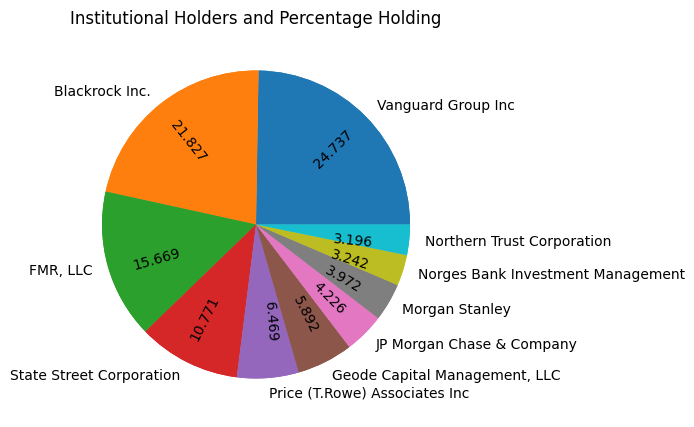

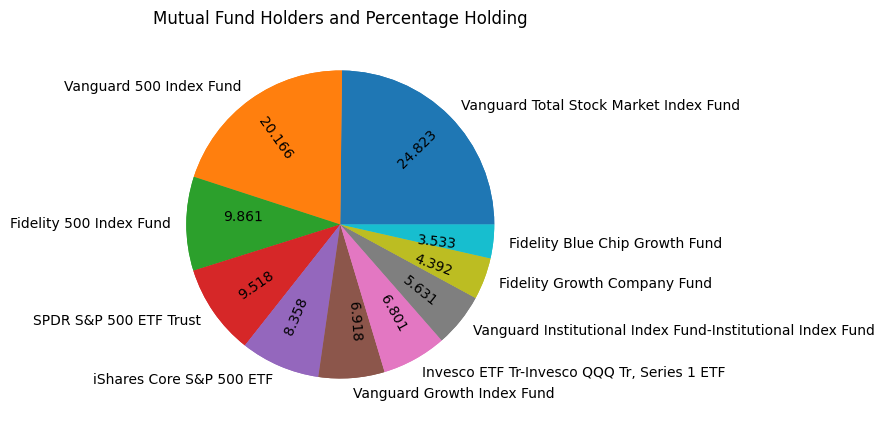

<Figure size 640x480 with 0 Axes>

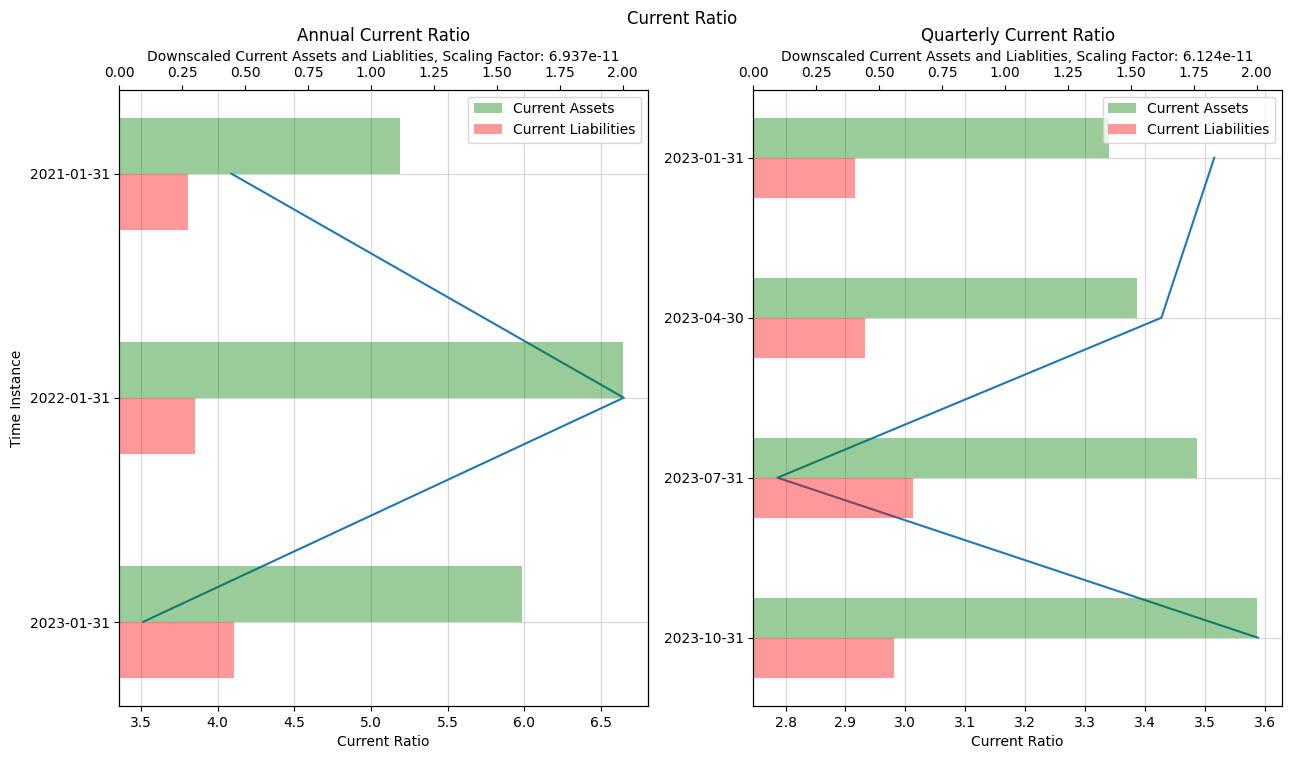

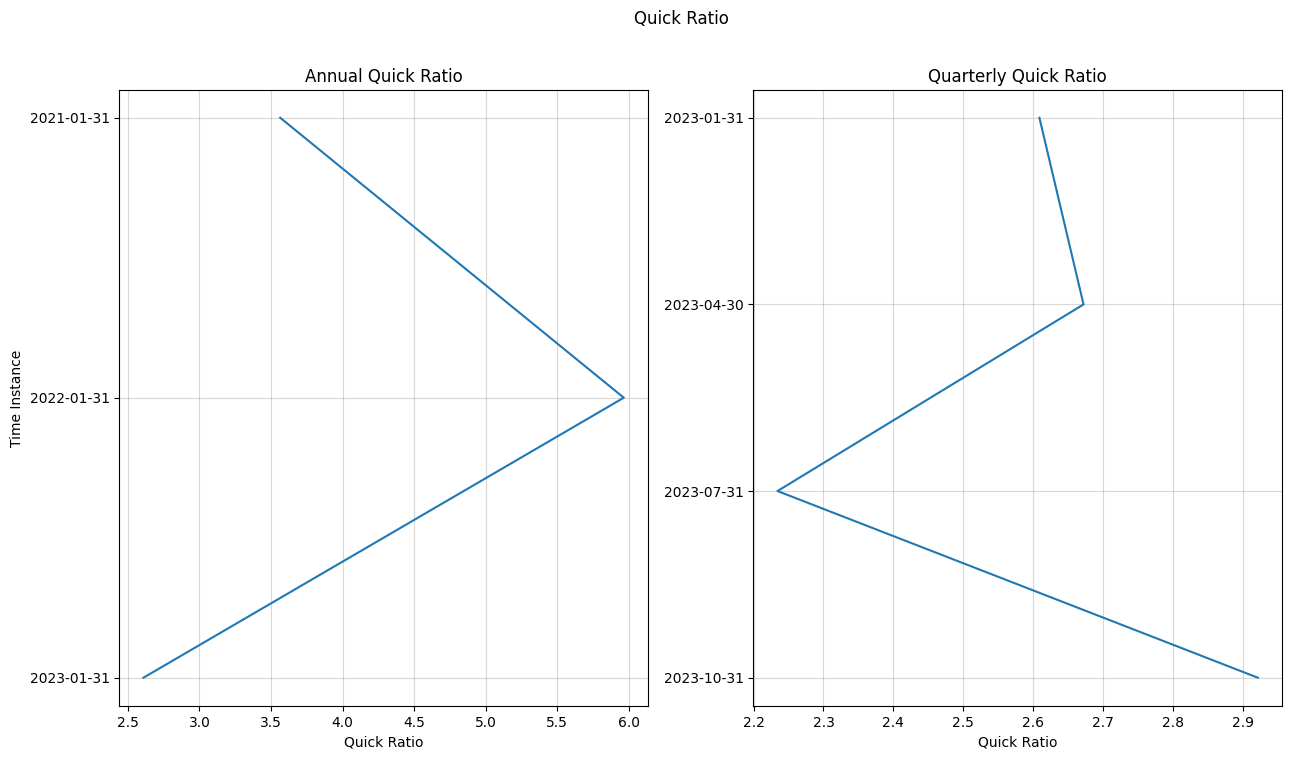

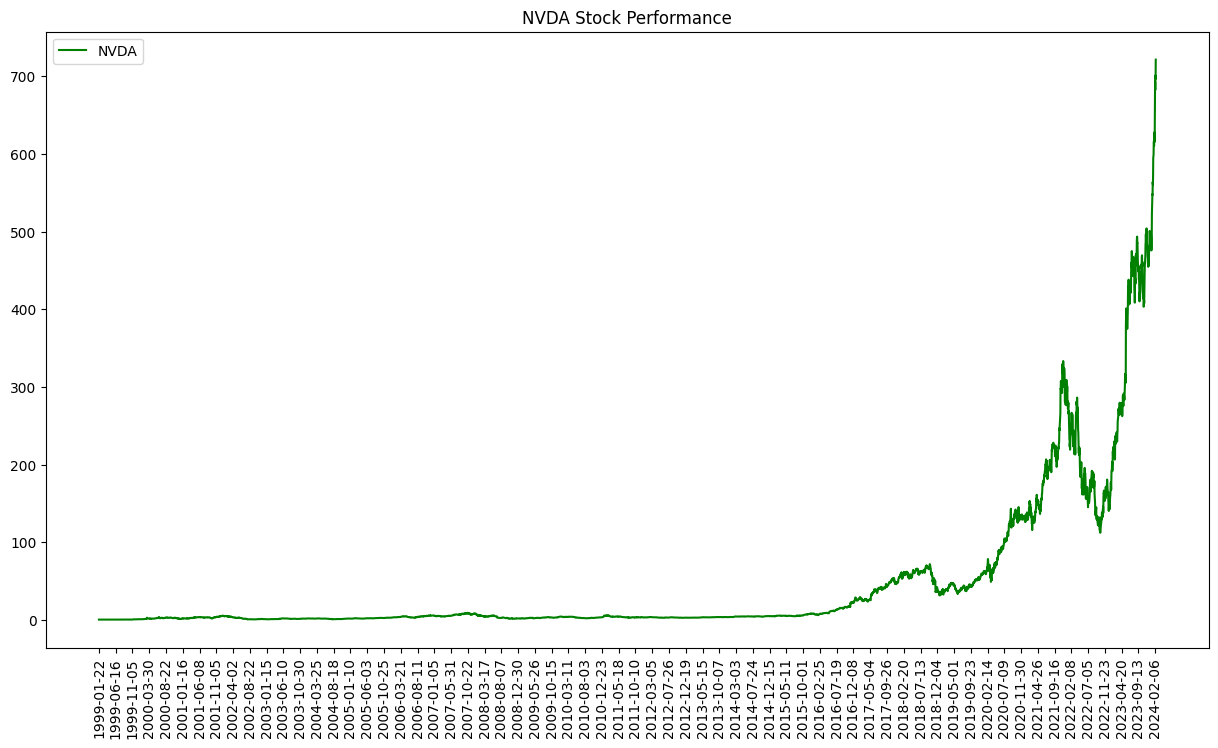

In [5]:
symbol = 'NVDA'
with open('Report.md','w') as file:
    file.write(getSymbolReport(symbol = symbol))
file.close()

## **NVIDIA Corporation**<br>
longName: NVIDIA Corporation<br>
website: https://www.nvidia.com<br>
sector: Technology<br>
industry: Semiconductors<br>

### **Business Summary**<br>
NVIDIA Corporation provides graphics, and compute and networking solutions in the United States, Taiwan, China, and internationally. The company's Graphics segment offers GeForce GPUs for gaming and PCs, the GeForce NOW game streaming service and related infrastructure, and solutions for gaming platforms; Quadro/NVIDIA RTX GPUs for enterprise workstation graphics; vGPU software for cloud-based visual and virtual computing; automotive platforms for infotainment systems; and Omniverse software for building 3D designs and virtual worlds. Its Compute & Networking segment provides Data Center platforms and systems for AI, HPC, and accelerated computing; Mellanox networking and interconnect solutions; automotive AI Cockpit, autonomous driving development agreements, and autonomous vehicle solutions; cryptocurrency mining processors; Jetson for robotics and other embedded platforms; and NVIDIA AI Enterprise and other software. The company's products are used in gaming, professional visualization, datacenter, and automotive markets. NVIDIA Corporation sells its products to original equipment manufacturers, original device manufacturers, system builders, add-in board manufacturers, retailers/distributors, independent software vendors, Internet and cloud service providers, automotive manufacturers and tier-1 automotive suppliers, mapping companies, start-ups, and other ecosystem participants. It has a strategic collaboration with Kroger Co. NVIDIA Corporation was incorporated in 1993 and is headquartered in Santa Clara, California.
### **Employee Details**<br>
fullTimeEmployees: 26196<br>
majorEmployees:<br>
- Mr. Jen-Hsun  Huang: Co-Founder, CEO, President & Director<br>
- Ms. Colette M. Kress: Executive VP & CFO<br>
- Ms. Debora  Shoquist: Executive Vice President of Operations<br>
- Mr. Timothy S. Teter: Executive VP, General Counsel & Secretary<br>
- Mr. Ajay K. Puri: Executive Vice President of Worldwide Field Operations<br>
- Mr. Chris A. Malachowsky: Co-Founder<br>
- Mr. Donald F. Robertson Jr.: VP & Chief Accounting Officer<br>
- Prof. William J. Dally: Chief Scientist & Senior VP of Research<br>
- Ms. Simona  Jankowski C.F.A., J.D.: Vice President of Investor Relations<br>
- Mr. Robert  Sherbin: Vice President of Corporate Communications<br>
### **Recent Company News**<br>
title: My 3 Monster AI Growth Stocks to Buy Hand Over Fist in the New Bull Market<br>
link: https://finance.yahoo.com/m/14a12815-73e1-3b7f-9e55-85a719189c64/my-3-monster-ai-growth-stocks.html<br>
publisher: Motley Fool<br>
<br>
title: How soon until the S&P 500 tops 6,000?<br>
link: https://finance.yahoo.com/m/1086f97f-50f6-3e8a-8781-b99435badeaf/how-soon-until-the-s%26p-500.html<br>
publisher: TheStreet<br>
<br>
title: Billionaire David Tepper Has Invested 38% of His Portfolio in These 5 Dividend Stocks<br>
link: https://finance.yahoo.com/m/149debcf-d92d-3152-97e3-6c9c482a8adb/billionaire-david-tepper-has.html<br>
publisher: Motley Fool<br>
<br>
title: This Top Tech Analyst Says It's 1995 Again: 3 AI Stocks to Buy If He's Right<br>
link: https://finance.yahoo.com/m/a644166d-9b29-3bf7-ac7c-36121b9f86d5/this-top-tech-analyst-says.html<br>
publisher: Motley Fool<br>
<br>
title: Artificial Intelligence (AI) Spending Could Soar 820% by 2030: 1 Surefire Index Fund to Buy Now, and 3 Index Funds to Avoid<br>
link: https://finance.yahoo.com/m/978010a7-24da-3b03-829c-29af6e0c6703/artificial-intelligence-%28ai%29.html<br>
publisher: Motley Fool<br>
<br>
title: 3 AI Dividend Stocks to Explode in 2024<br>
link: https://finance.yahoo.com/m/a7ae69aa-d885-3e04-9c28-b7fe43fafcef/3-ai-dividend-stocks-to.html<br>
publisher: Motley Fool<br>
<br>
title: Should You Buy Celsius Stock Hand Over Fist With $100 Right Now?<br>
link: https://finance.yahoo.com/m/0f672fc7-a679-39d5-9eb0-e71e463da331/should-you-buy-celsius-stock.html<br>
publisher: Motley Fool<br>
<br>
title: Missed Out on Nvidia? 2 Artificial Intelligence (AI) Stocks to Buy Before They Soar in 2024<br>
link: https://finance.yahoo.com/m/5fb8587f-aa7c-376b-9892-37ca279797a4/missed-out-on-nvidia%3F-2.html<br>
publisher: Motley Fool<br>
<br>
### **Investor Data**<br>
![Institutional Holders and Percentage Holding](./ReportMedia/Institutional_Holders_and_Percentage_Holding.png)<br>
![Mutual_Fund_Holders_and_Percentage_Holding](./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png)<br>
### **Latest Financials**<br>
#### General Financials<br>
totalRevenue: 44870000640<br>
totalDebt: 11027000320<br>
totalCash: 18281000960<br>
enterpriseValue: 1774431109120<br>
bookValuePerShare: 13.489<br>
marketCap: 1781685288960<br>
#### Liquidity Ratios<br>
![Current Ratio](./ReportMedia/Current_Ratio.png)<br>
![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>
### Technical Information<br>
![Stock vs S&P500](./ReportMedia/Stock_vs_S&P.png)